# 官網找資料

In [1]:
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [2]:
random.seed(9001)
cmap = cm.get_cmap('Spectral')
color = sns.color_palette()
pd.set_option('display.float_format', lambda x: '%.2f' % x)


### Import dataset

In [13]:
col = ["time","s_stat","e_stat","type_car","tv","number"]
def loading(path):
    df = pd.read_csv(path)
    df.columns = col
    df1 = df[(df.s_stat == '01F0750S')&(df.e_stat == '01F0880S')]
    df2 = df[(df.s_stat == '01F0880S')&(df.e_stat == '01F0928S')]
    df3 = df[(df.s_stat == '01F0928S')&(df.e_stat == '01F0950S')]
    df4 = pd.concat([df1, df2, df3], axis=0)
    df5 = df4[(df4.type_car == "31")].reset_index(drop=True)
    return df5

def preprocessing(df):
    # processing time string
    con = pd.DataFrame(df.mins.str.split(" ",2).tolist(), columns = ['day','time'])
    con1 = pd.DataFrame(con.day.str.split("/",3).tolist(), columns = ['year','mon','day'])
    con2 = pd.DataFrame(con.time.str.split(":",2).tolist(), columns = ['hr','mins'])
    con2.hr = pd.to_numeric(con2.hr, errors = 'coerce')
    con2.mins = pd.to_numeric(con2.mins, errors = 'coerce')
    df = pd.concat([con1, df],axis=1)
    df["mins"] = con2.hr*60 + con2.mins
    
    df.number = pd.to_numeric(df.number, errors = 'coerce')
    df.clock = pd.to_numeric(df.clock, errors = 'coerce')
    df.speed = pd.to_numeric(df.speed, errors = 'coerce')
    return df


In [4]:
path = 'M04A'
allfile = glob.glob(path + "/*.csv")
df_t = pd.DataFrame()
list_ = []

for file_ in allfile:
    df = loading(file_)
    list_.append(df)
df_t = pd.concat(list_).reset_index(drop=True)
df_t.tail()

,time,s_stat,e_stat,type_car,tv,number
7771,2017/09/09 23:35,01F0928S,01F0950S,31,72,59
7772,2017/09/09 23:40,01F0928S,01F0950S,31,75,49
7773,2017/09/09 23:45,01F0928S,01F0950S,31,74,55
7774,2017/09/09 23:50,01F0928S,01F0950S,31,77,63
7775,2017/09/09 23:55,01F0928S,01F0950S,31,73,45


In [5]:
path = 'M05A'
allfile = glob.glob(path + "/*.csv")
df_v = pd.DataFrame()
list_ = []

for file_ in allfile:
    df = loading(file_)
    list_.append(df)
df_v = pd.concat(list_).reset_index(drop=True)
df_v.tail()

,time,s_stat,e_stat,type_car,tv,number
7771,2017/09/09 23:35,01F0928S,01F0950S,31,110,59
7772,2017/09/09 23:40,01F0928S,01F0950S,31,105,49
7773,2017/09/09 23:45,01F0928S,01F0950S,31,107,55
7774,2017/09/09 23:50,01F0928S,01F0950S,31,103,63
7775,2017/09/09 23:55,01F0928S,01F0950S,31,108,45


In [14]:
df = pd.merge(df_t, df_v, on=['time','s_stat','e_stat','type_car','number'], how='inner')
df.columns = ['mins','s_stat','e_stat','type_car','clock','number','speed']
df = preprocessing(df)
df = df.drop(["type_car"], axis=1)
df.to_csv("M0405.csv", index=False)
df.head()

,year,mon,day,mins,s_stat,e_stat,clock,number,speed
0,2017,09,01,0,01F0750S,01F0880S,442,46,106
1,2017,09,01,5,01F0750S,01F0880S,447,31,105
2,2017,09,01,10,01F0750S,01F0880S,426,39,110
3,2017,09,01,15,01F0750S,01F0880S,441,41,106
4,2017,09,01,20,01F0750S,01F0880S,442,31,106


In [18]:
df = pd.read_csv("M0405.csv")
df.shape

(7776, 9)

### focus on ('01F0750S', '01F0880S') ('01F0880S', '01F0928S') ('01F0928S', '01F0950S')

In [34]:
X = df[(df.s_stat == '01F0880S')].reset_index(drop=True)

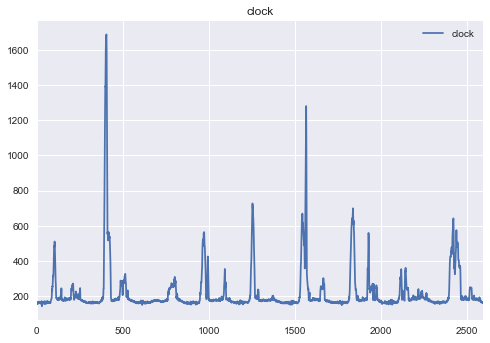

In [35]:
# clock time series
X.plot(x=X.index, y='clock', title="clock")
plt.show()

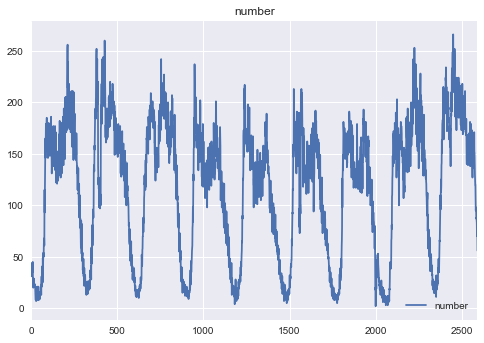

In [36]:
# number time series
X.plot(x=X.index, y='number', title="number")
plt.show()

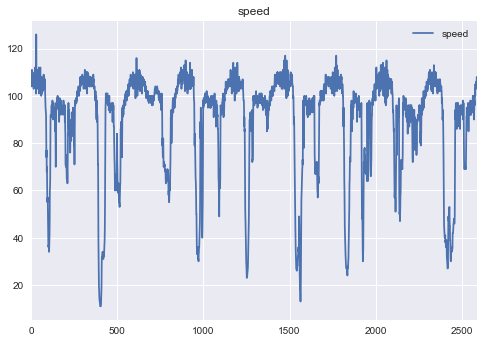

In [37]:
# speed time series
X.plot(x=X.index, y='speed', title="speed")
plt.show()

### 抓出每日五分鐘的樞紐，看出一天之中的尖峰離峰時段

In [38]:
f = {'clock':['count','max','min','mean'],
     'number':['max','min','mean'],
     'speed':['max','min','mean']}
g = X.groupby(["mins"]).aggregate(f).reset_index()
g.columns = ["mins","c_count","c_max","c_min","c_mean","n_max","n_min","n_mean","s_max","s_min","s_mean"]
g.head()

,mins,c_count,c_max,c_min,c_mean,n_max,n_min,n_mean,s_max,s_min,s_mean
0,0,9,168,159,163.56,68,33,49.78,109,103,105.67
1,5,9,164,158,161.56,59,31,44.56,110,106,107.11
2,10,9,164,157,160.78,77,33,49.33,110,105,107.22
3,15,9,165,156,160.89,85,26,50.11,110,104,107.22
4,20,9,165,158,162.11,76,29,48.78,109,104,106.33


In [39]:
def subplot(ijk, x_):
    plt.subplot(ijk)
    sns.barplot(g.index, x_, alpha = 0.8)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('Number of products in the given order', fontsize=12)
    plt.xticks(rotation='vertical')


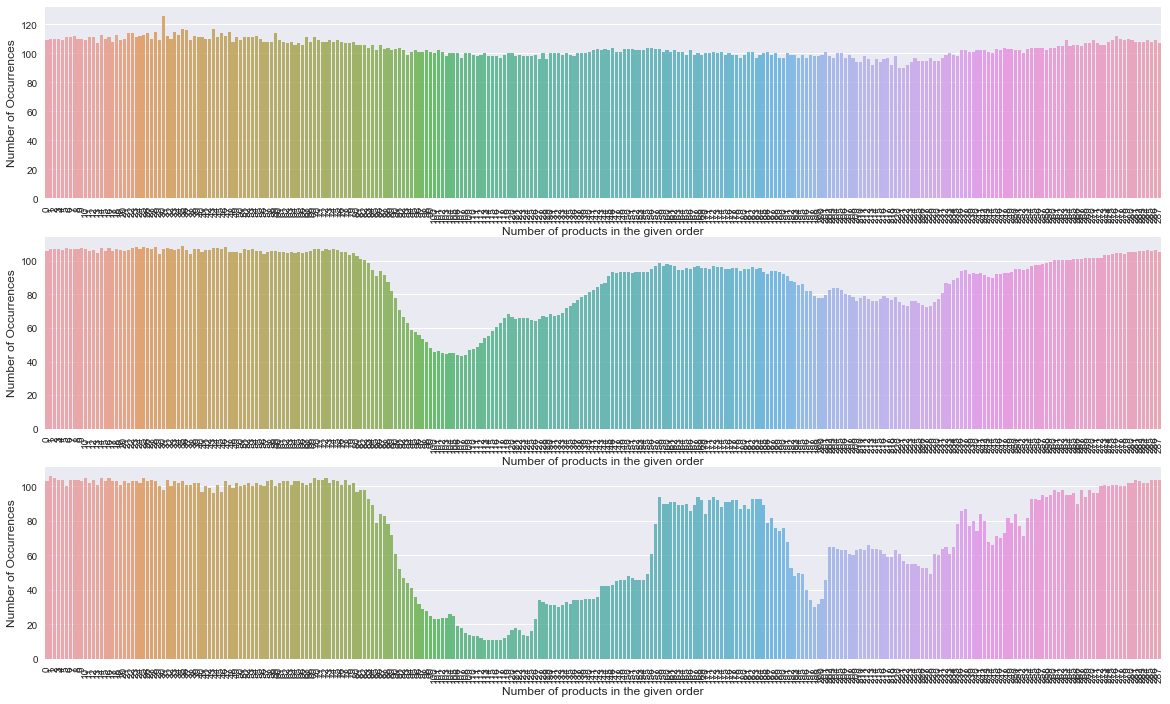

In [40]:
# speed
plt.figure(figsize=(20, 12))

subplot(311, g.s_max)
subplot(312, g.s_mean)
subplot(313, g.s_min)

plt.show()

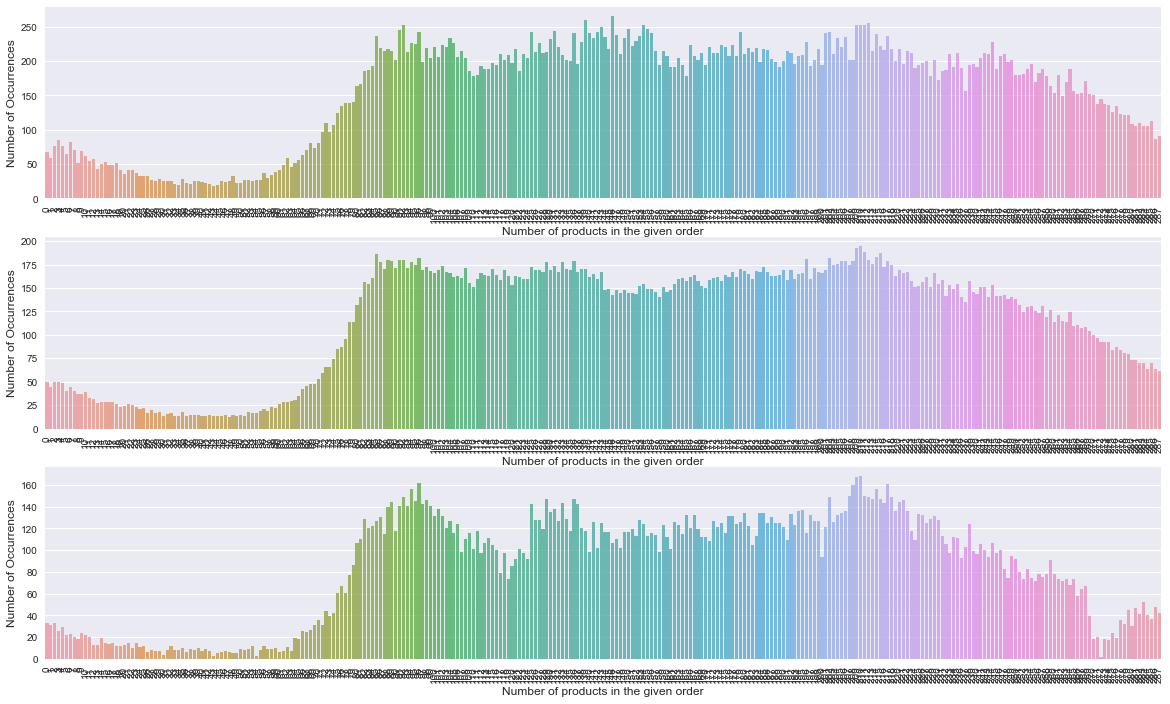

In [41]:
# number
plt.figure(figsize=(20, 12))

subplot(311, g.n_max)
subplot(312, g.n_mean)
subplot(313, g.n_min)

plt.show()

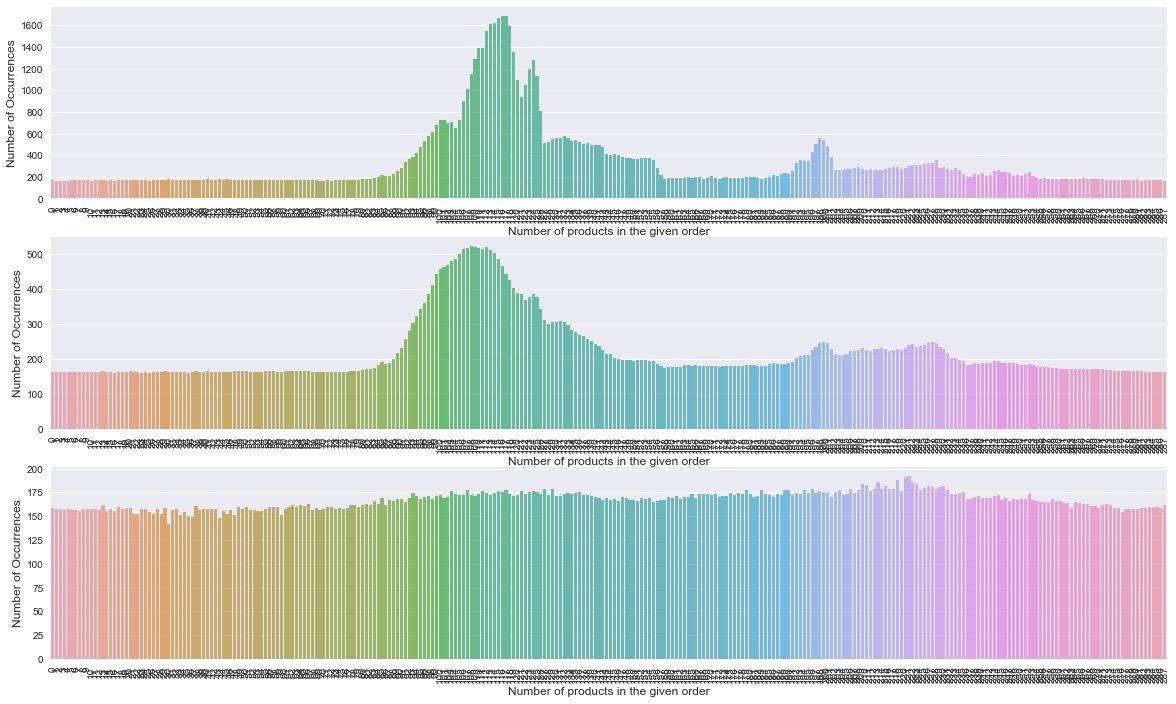

In [42]:
# clock
plt.figure(figsize=(20, 12))

subplot(311, g.c_max)
subplot(312, g.c_mean)
subplot(313, g.c_min)

plt.show()

### Use kmeans to find abnormal point

In [49]:
def kmeans_plot(n_clusters, df):
    X = df[["clock","number","speed"]]
    # kmeans
    kmeans = KMeans(n_clusters = n_clusters, random_state = 0).fit(X)
    label_kmeans = pd.DataFrame(kmeans.labels_, columns=["k_label"])
    # 降維看結果
    pca = PCA(n_components = 2)
    X_pca = pd.DataFrame(pca.fit_transform(X), columns=["pc1", "pc2"])
    df_pca = pd.concat([X_pca, label_kmeans], axis = 1)
    df = pd.concat([df, label_kmeans], axis = 1)
    print(df_pca.k_label.value_counts())
    # plot
    fig, ax = plt.subplots(figsize=(12, 8))
    df_pca.plot(x='pc1', y='pc2', ax = ax, title="Kmaens",
                   kind='scatter', s=30, c='k_label', cmap=cmap, alpha=0.8)
    plt.show()
    return df_pca, df


0    4992
1    2784
Name: k_label, dtype: int64


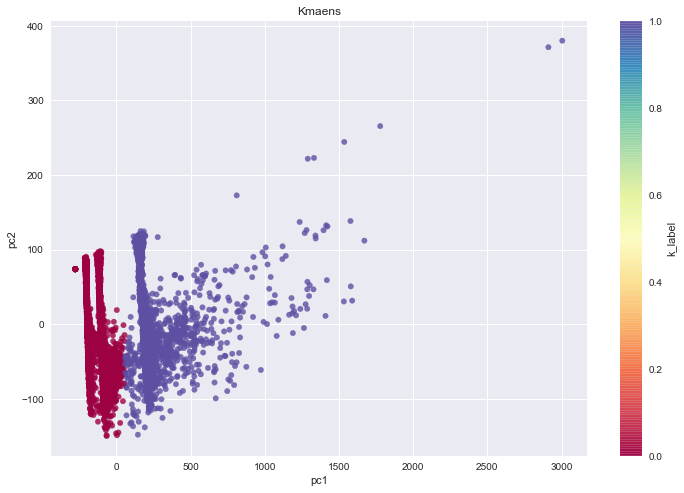

1    4972
0    2661
2     143
Name: k_label, dtype: int64


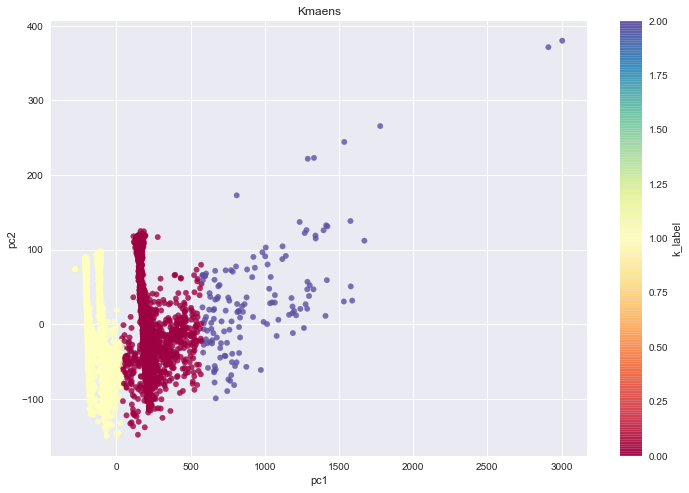

0    4955
1    2471
2     291
3      59
Name: k_label, dtype: int64


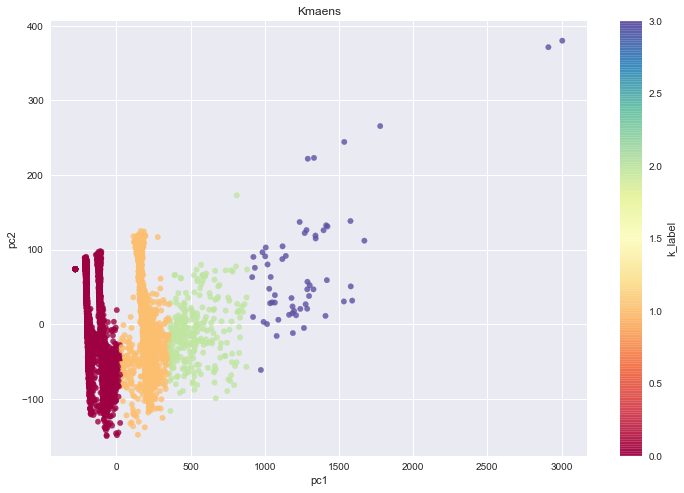

4    3317
2    2426
1    1685
0     289
3      59
Name: k_label, dtype: int64


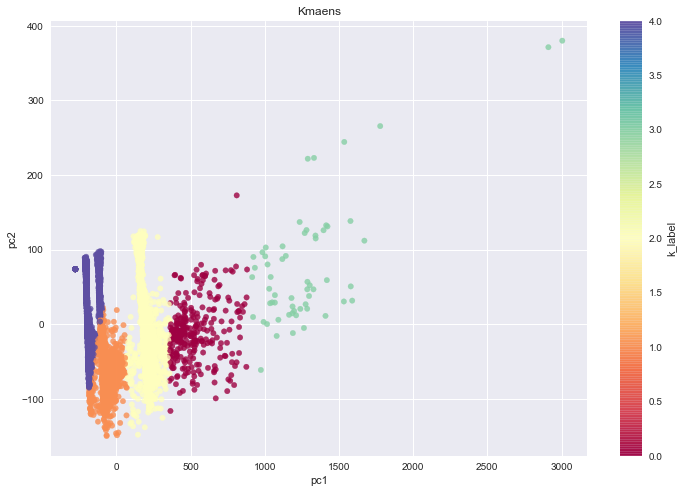

4    3319
1    1686
0    1577
2     875
5     262
3      57
Name: k_label, dtype: int64


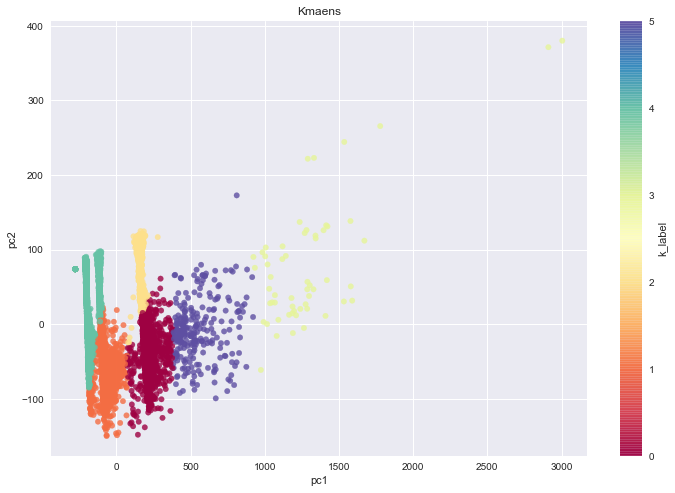

In [50]:
for i in range(2,7):
    df_pca = kmeans_plot(i, df)


3    1198
1     886
4     330
0     160
2      18
Name: k_label, dtype: int64


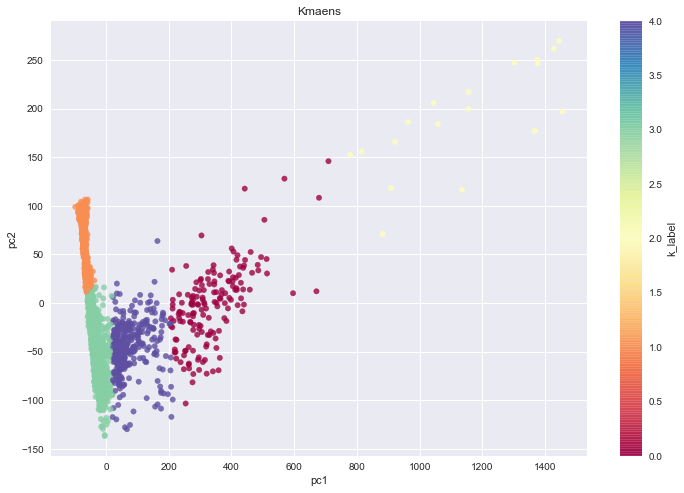

,year,mon,day,mins,s_stat,e_stat,clock,number,speed,k_label
0,2017,9,1,0,01F0880S,01F0928S,163,44,106,1
1,2017,9,1,5,01F0880S,01F0928S,162,31,107,1
2,2017,9,1,10,01F0880S,01F0928S,161,35,107,1
3,2017,9,1,15,01F0880S,01F0928S,156,43,110,1
4,2017,9,1,20,01F0880S,01F0928S,165,41,104,1


In [58]:
df_pca, df_ = kmeans_plot(5, X)
df_.head()

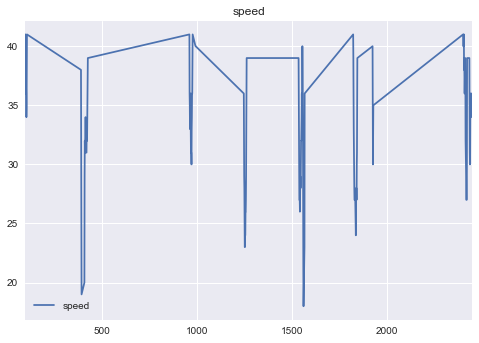

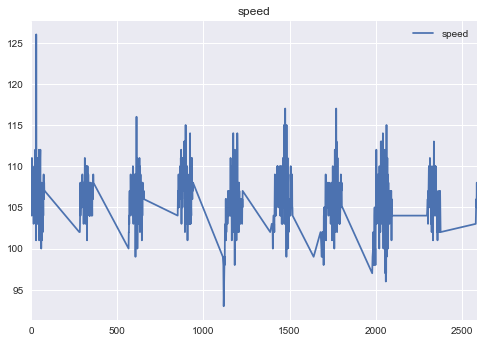

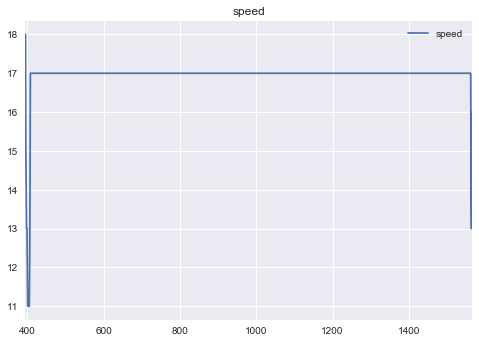

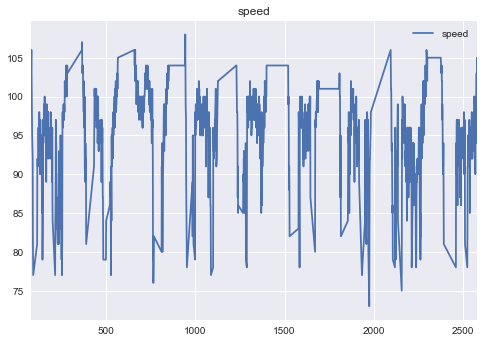

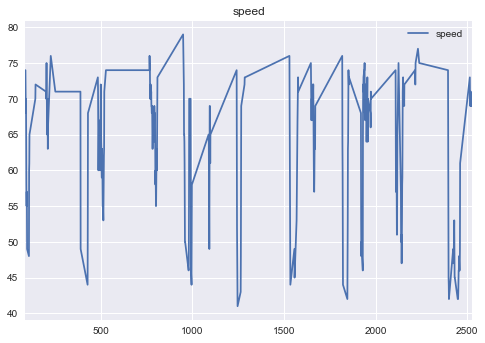

In [62]:
def time_plot(label):
    df_[(df_.k_label == label)].plot(x=df_[(df_.k_label == label)].index, y='speed', title="speed")

for i in range(np.max(df_.k_label)+1):
    time_plot(i)
plt.show()

In [67]:
print ("Speed 0~20  :", df_[(df_.k_label == 2)].shape[0])
print ("Speed 20~40 :", df_[(df_.k_label == 0)].shape[0])
print ("Speed 40~75 :", df_[(df_.k_label == 4)].shape[0])


Speed 0~20  : 18
Speed 20~40 : 160
Speed 40~75 : 330


> 利用kmeans可以即時偵測出塞車的點。